# _Portulaca amilis_ genome analyses and plotting
This notebook contains a number of different analyses and plots of data from the annotation of the _Portulaca amilis_ genome. This includes

1. Plotting _P. amilis_ contig and BUSCO statistics relative to currently available plant genomes
2. Production of a [repeat landscape plots](http://repeatmasker.org/genomicDatasets/RMGenomicDatasets.html) from `RepeatMasker` output files
3. References

In [91]:
# Core
import re, os, glob, sys
import pandas as pd
from pandas.compat import StringIO
from scipy import stats
from itertools import cycle, islice
import numpy as np
import csv
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 1. The _P. amilis_ genome relative to currently available plant geneome
Using supplementary data from [Zhao and Schranz (2019)](https://www.pnas.org/content/116/6/2165), which contains statistics on genome size, N50, and BUSCO completeness, I'll compare the _P. amilis_ genome assembly and annotations to ~100 angiosperm genomes.

In [36]:
angiogenomes = pd.read_csv("../Data/Zhao_Schranz_2019/Angiosperm.csv")
angiogenomes.head()

,No.,Lineage,Family,Species,Order,Family.1,Common Name,Abbreviation,Assembly_Version,Source,#Gene_models,N50 (Mb),Size (Mb),Scaffolds,BUSCO,Resource,Average_Syntenic_Percentage
0,35,Angiosperms,Rosids,Arabidopsis thaliana,Brassicales,Brassicaceae,Thale cress,ath,TAIR10,Phytozome,27416,23.5,135,7,"C:99.3%[S:98.3%,D:1.0%],F:0.3%,M:0.4%,n:1440",https://phytozome.jgi.doe.gov/pz/portal.html,29.76
1,36,Angiosperms,Rosids,Camelina sativa,Brassicales,Brassicaceae,False flax,Csat,Cs,NCBI,82569,30.1,641,37212,"C:99.2%[S:3.1%,D:96.1%],F:0.4%,M:0.4%,n:1440",https://www.ncbi.nlm.nih.gov/genome/?term=Came...,28.37
2,13,Angiosperms,Rosids,Prunus persica,Rosales,Rosaceae,Peach,ppe,v2.1,Phytozome,26873,27.4,227,191,"C:98.8%[S:97.5%,D:1.3%],F:0.8%,M:0.4%,n:1440",https://phytozome.jgi.doe.gov/pz/portal.html,34.60
3,85,Angiosperms,Monocots,Brachypodium distachyon,Poales,Poaceae,Stiff Brome,bdi,v3.1,Phytozome,34310,22.0,272,27,"C:98.6%[S:97.4%,D:1.2%],F:0.8%,M:0.6%,n:1440",https://phytozome.jgi.doe.gov/pz/portal.html,12.49
4,41,Angiosperms,Rosids,Thellungiella halophila,Brassicales,Brassicaceae,Salt cress,thh,173,Brassica Database,29284,8.0,241,639,"C:98.5%[S:86.3%,D:12.2%],F:0.7%,M:0.8%,n:1440",http://brassicadb.org/brad/,27.90


In [37]:
complete, single, duplicated, fragmented, missing = [], [], [], [], []
for taxon in angiogenomes["BUSCO"]:
    complete.append(float(re.findall(pattern="C:([0-9\.]+)", string=taxon)[0]))
    single.append(float(re.findall(pattern="S:([0-9\.]+)", string=taxon)[0]))
    duplicated.append(float(re.findall(pattern="D:([0-9\.]+)", string=taxon)[0]))
    fragmented.append(float(re.findall(pattern="F:([0-9\.]+)", string=taxon)[0]))
    missing.append(float(re.findall(pattern="M:([0-9\.]+)", string=taxon)[0]))
angiogenomes["Complete"] = complete
angiogenomes["Single"] = single
angiogenomes["Duplicated"] = duplicated
angiogenomes["Fragmented"] = fragmented
angiogenomes["Missing"] = missing

Now I'll add the data I have for _Portulaca amilis_.

In [38]:
angiogenomes = angiogenomes.append({"Lineage":"Angiosperms", "Family":"Super-Asterids", "Species":"Portulaca amilis",
                    "Order":"Caryophyllales", "Family.1":"Portulacaceae", "N50 (Mb)":42.597560,
                    "Size (Mb)":403.885173, "Scaffolds":9, "Complete":89.7, "Single":85.3, "Duplicated":4.4,
                    "Fragmented":2.0, "Missing":8.33}, ignore_index=True)

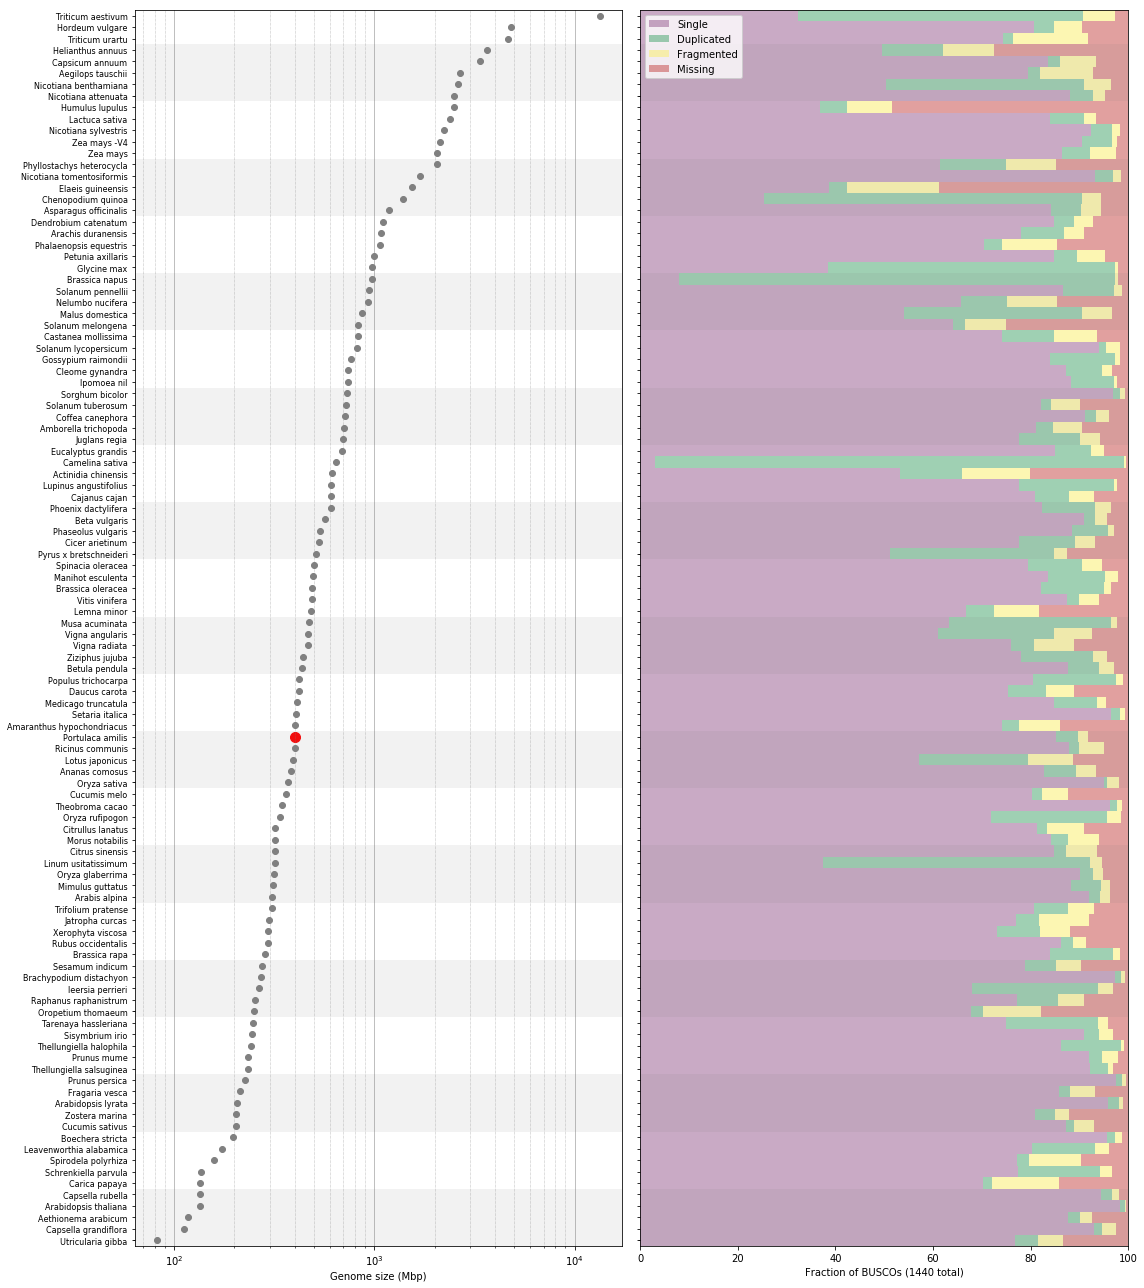

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,18), sharey=True)

buscolors = list(islice(cycle(['xkcd:purplish', 'xkcd:greenish', 'xkcd:yellowish', 'xkcd:reddish']), None, len(bysize)))

bysize = angiogenomes.sort_values(by="Size (Mb)").reset_index()

for i in range(0, 110, 10):
    ax[0].axhspan(i-0.5, i+4.5, facecolor='grey', alpha=0.1)
    
ax[0].scatter(x=bysize["Size (Mb)"], y=range(len(angiogenomes)), color="grey")
ax[0].scatter(x=bysize[bysize["Species"]=="Portulaca amilis"]["Size (Mb)"],
            y=bysize[bysize["Species"]=="Portulaca amilis"].index[0],
            c="red", s=100)

bysize[["Single", "Duplicated", "Fragmented", "Missing"]].plot.barh(stacked=True, ax = ax[1], 
    align="center", width=1, color=buscolors, alpha=0.5)
for i in range(0, 110, 10):
    ax[1].axhspan(i-0.5, i+4.5, facecolor='grey', alpha=0.1)

ax[0].grid(axis= "x", which='major', linestyle='-', linewidth='0.5', color='grey')
ax[0].grid(axis= "x", which='minor', linestyle=':', linewidth='0.5', color='grey')
ax[0].set_yticks(range(len(angiogenomes)))
ax[0].set_yticklabels(angiogenomes.sort_values(by="Size (Mb)")["Species"], size=8)
ax[0].set_ylim([-0.5, len(angiogenomes)-0.5])
ax[0].semilogx()
ax[0].set_xlabel("Genome size (Mbp)")

ax[1].set_xlim([0,100])
ax[1].set_xlabel("Fraction of BUSCOs (1440 total)")
plt.tight_layout()
# plt.savefig("../Figures/Gsize.BUSCO.pdf", dpi = 100, transparent=True)

## Repeat Analysis

In [65]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True, seed=None):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks.
    See StackExchange (https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib)
    for where this originated.
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :param seed: Set random seed for reproducibility
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    np.random.seed(seed=seed)
    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

## Load data

In [83]:
pamilis_dir = "../Data/RepeatMasker/P_amilis/"
pamilis_rfam = pd.read_csv(glob.glob(datadir+"*.Rfam.tab")[0], sep="\t", skiprows=1)

allmask_dir = "/Users/iangilman/Dropbox/P_amilis_genome_project/RepeatMasker/Viridiplantae_mask_2/"
allmask_rfam = pd.read_csv(glob.glob(allmask_dir+"*.Rfam.tab")[0], sep="\t", skiprows=1)

allmask_rfam.head()

,Rclass,Rfam,[0;1[,[1;2[,[2;3[,[3;4[,[4;5[,[5;6[,[6;7[,[7;8[,...,[40;41[,[41;42[,[42;43[,[43;44[,[44;45[,[45;46[,[46;47[,[47;48[,[48;49[,[49;50[
0,RC,Helitron?,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DNA,CMC-EnSpm,32,0,0,85,41,77,195,386,...,0,0,0,0,0,0,0,0,0,0
2,LTR,Caulimovirus,63,0,0,55,0,0,61,0,...,0,0,0,0,0,0,0,0,0,0
3,LTR,DIRS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,LINE,L1-Tx1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To get it into a form ammenable to repeat landscape plots (i.e. stack barcharts) we'll convert the units of basepairs into fraction of genome, transpose the dataframe, and use the repeat families as columns.

In [84]:
# Rename columns
new_cols = []
for col in pamilis_rfam.columns:
    if col.startswith("["): new_cols.append("-".join(re.findall("\d+", col)))
    else: new_cols.append(col)
pamilis_rfam.columns = new_cols

# Convert to percentages
genome_size = 403885173
pamilis_rfam[pamilis_rfam.select_dtypes(include=['number']).columns] /= genome_size

# Transpose and set families as columns
pamilis_rfam = pamilis_rfam.T[1:]
pamilis_rfam.columns = pamilis_rfam.iloc[0]
pamilis_rfam[1:].reset_index(drop=True)
pamilis_rfam = pamilis_rfam[1:].reset_index(drop=True)

pamilis_rfam.head()

Rfam,Retro,RTE-BovB,Maverick,MULE-MuDR,DNA,LINE,Ginger-1,hAT-hATm,Helitron,CMC-EnSpm,...,L2,nonLTR,hAT,Gypsy,LTR,hAT-Ac,R2-NeSL,hAT-Tag1,Cassandra,Unknown
0,2.42074e-05,2.62451e-06,1.0399e-07,1.5648e-06,0.000100628,0.000299877,6.93266e-08,0,9.68097e-07,2.13947e-05,...,0,5.12522e-07,0,2.03647e-05,5.05243e-05,7.58384e-06,2.79782e-07,0,7.08122e-07,1.21916e-05
1,8.20728e-05,8.19045e-06,0,3.9224e-05,0.000446194,0.000169964,0,0,4.01104e-06,7.66505e-05,...,7.93047e-06,2.23826e-06,0,0.000105926,0.0002062,8.63637e-05,1.33701e-07,5.17474e-07,1.32736e-05,8.39075e-05
2,0.000158723,5.85488e-05,1.18846e-07,0.000107167,0.00066385,0.000207282,1.73317e-07,0,9.78991e-06,0.000121958,...,1.69479e-05,6.02151e-06,8.66583e-08,0.000779472,0.000523837,0.000371457,0,4.0977e-06,4.34381e-05,0.000313163
3,0.000254558,9.15582e-05,0,0.000229261,0.00109742,0.000492286,0,0,2.55568e-05,0.000149245,...,2.74608e-05,2.71488e-05,5.84324e-07,0.00199601,0.000906443,0.000466687,2.57499e-07,1.87628e-05,0.000106478,0.000567963
4,0.000579368,0.000150362,1.06466e-07,0.00017987,0.00178438,0.000788999,2.47595e-07,0,3.94691e-05,0.00017634,...,5.79373e-06,5.69444e-05,5.14998e-07,0.00236067,0.00122912,0.000652227,6.63555e-07,2.06296e-05,0.000180532,0.000713319


In [85]:
# Rename columns
new_cols = []
for col in allmask_rfam.columns:
    if col.startswith("["): new_cols.append("-".join(re.findall("\d+", col)))
    else: new_cols.append(col)
allmask_rfam.columns = new_cols

# Convert to percentages
genome_size = 403885173
allmask_rfam[allmask_rfam.select_dtypes(include=['number']).columns] /= genome_size

# Transpose and set families as columns
allmask_rfam = allmask_rfam.T[1:]
allmask_rfam.columns = allmask_rfam.iloc[0]
allmask_rfam[1:].reset_index(drop=True)
allmask_rfam = allmask_rfam[1:].reset_index(drop=True)

allmask_rfam.head()

Rfam,Helitron?,CMC-EnSpm,Caulimovirus,DIRS,L1-Tx1,RTE-derived,Dualen,Copia,DNA?,Cassandra,...,PIF-Harbinger?,tRNA-RTE,tRNA,Retroposon,L1,Copia?,hAT-Ac,CRE,PIF-Harbinger,P
0,0,7.92304e-08,1.55985e-07,0,0,0,0,4.30816e-07,0,0,...,0,0,0,0,6.68507e-08,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,4.48147e-07,0,0,...,0,0,0,0,2.97114e-07,8.66583e-08,0,0,0,0
3,0,2.10456e-07,1.36177e-07,0,0,0,0,6.95742e-07,0,0,...,0,0,0,0,2.92162e-07,0,6.68507e-08,0,0,0
4,0,1.01514e-07,0,0,0,0,0,6.9079e-07,0,0,...,0,0,0,0,1.11418e-07,0,0,0,0,0


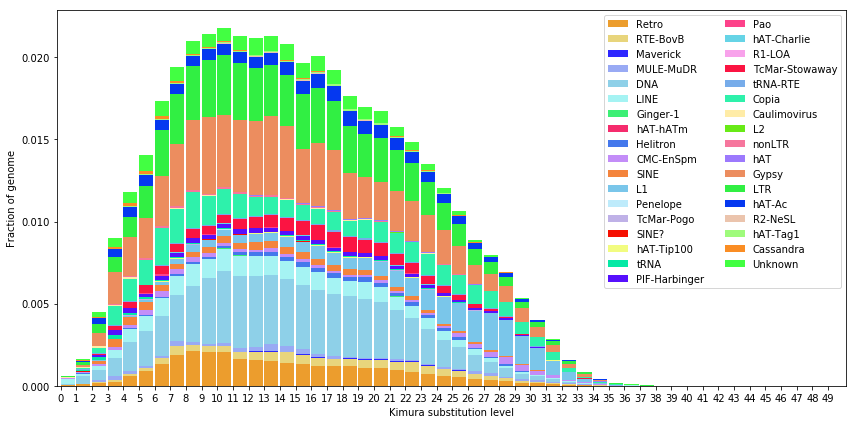

In [86]:
fig, ax = plt.subplots(figsize=(12,6))

mycmap = rand_cmap(nlabels=len(pamilis_rfam.columns), first_color_black=False, 
                   last_color_black=False, verbose=False, seed=19)

pamilis_rfam.plot.bar(stacked=True, ax = ax, align="edge", width=0.9, colormap=mycmap)
plt.legend(loc="upper right", ncol=2, fancybox=True)

ax.set_ylabel("Fraction of genome")
ax.set_xlabel("Kimura substitution level")

plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig("../Figures/P_amilis.repeatlandscape.pdf", dpi = 100, transparent=True)

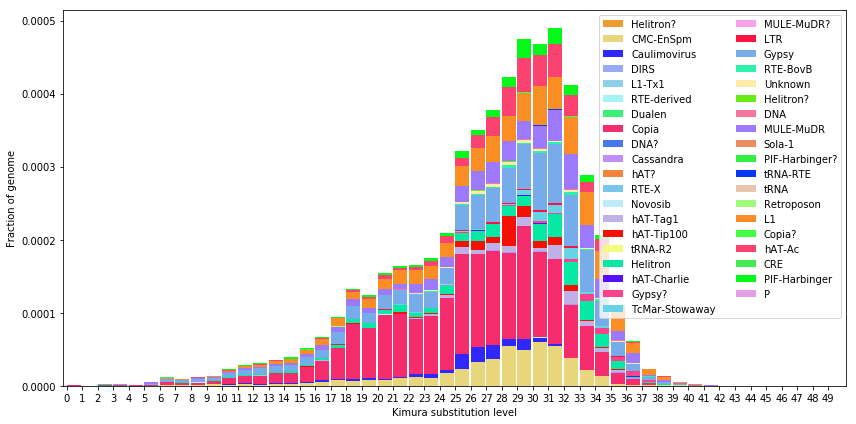

In [87]:
fig, ax = plt.subplots(figsize=(12,6))

mycmap = rand_cmap(nlabels=len(allmask_rfam.columns), first_color_black=False, 
                   last_color_black=False, verbose=False, seed=19)

allmask_rfam.plot.bar(stacked=True, ax = ax, align="edge", width=0.9, colormap=mycmap)
plt.legend(loc="upper right", ncol=2, fancybox=True)

ax.set_ylabel("Fraction of genome")
ax.set_xlabel("Kimura substitution level")

plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig("../Figures/P_amilis.repeatlandscape.pdf", dpi = 100, transparent=True)

### Fixing a broken `.gff` file
The `.gff` output by MAKER looks like 
```bash
##gff-version 3
Scaffold_27%3BHRSCAF%3D30	.	contig	1	3334	.	.	.	ID=Scaffold_27%3BHRSCAF%3D30;Name=Scaffold_27%3BHRSCAF%3D30
###
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match	12	199	1173	-	.	ID=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Name=342270;Target=342270 69 250 +
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match_part	12	199	1173	-	.	ID=Scaffold_27%3BHRSCAF%3D30:hsp:39:1.3.0.0;Parent=Scaffold_27%3BHRSCAF%3D30:hit:39:1.3.0.0;Target=342270 69 250 +
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match	374	3334	8096	+	.	ID=Scaffold_27%3BHRSCAF%3D30:hit:40:1.3.0.0;Name=342274;Target=342274 2731 3807 +
Scaffold_27%3BHRSCAF%3D30	repeat_gff:repeatmasker	match_part	374	3334	8096	+	.	ID=Scaffold_27%3BHRSCAF%3D30:hsp:40:1.3.0.0;Parent=Scaffold_27%3BHRSCAF%3D30:hit:40:1.3.0.0;Target=342274 2731 3807 +
###
Scaffold_3644%3BHRSCAF%3D4225	.	contig	1	1478	.	.	.	ID=Scaffold_3644%3BHRSCAF%3D4225;Name=Scaffold_3644%3BHRSCAF%3D4225
```
which has scaffold identifies that do not match the headers from `fasta` portion:
```bash
>Scaffold_402;HRSCAF=467
CGTGGATGCACCACCTTTTAAATTATGATCAAGTAGCAAACTTCAATTGGGCATCGGCTA...
>Scaffold_1436;HRSCAF=1659
ATCACCATGAGTGTAAATGCCTTATGGGAAGATCACGATGAAGAGGTTCTAGAGATCAGC...
>Scaffold_695;HRSCAF=808
GAATTCGCCAAATATCGAATGTAATTCGAGCGACGCCTAAATGATGACTTTTCATTGCGA...
>Scaffold_2264;HRSCAF=2617
GAAAGCTTCTGATTTTTCCTGCAAGAAATAGACCCAAGTCTTTCGAGAAAAATCATCAAT...
```

I'm going to try a little regex work to convert something like `Scaffold_27%3BHRSCAF%3D30` to `Scaffold_27;HRSCAF=30` and see if this solves downstream problems.

In [32]:
broken_path = "/Users/iangilman/Dropbox/P_amilis_genome_project/portulaca_26Nov2018_oK3Ko.fasta.fai"
with open (broken_path, "r") as b:
    brokenlines = b.readlines()
brokenlines[:5]

['Scaffold_1;HRSCAF=1\t1270\t21\t100\t101\n',
 'Scaffold_2;HRSCAF=2\t1040\t1325\t100\t101\n',
 'Scaffold_3;HRSCAF=3\t1830\t2397\t100\t101\n',
 'Scaffold_4;HRSCAF=5\t1235\t4267\t100\t101\n',
 'Scaffold_5;HRSCAF=6\t3180\t5536\t100\t101\n']

In [33]:
def gff_line_fixer(line):
    return re.sub(pattern=r"[%3B;]HRSCAF[%3D=]\d+", repl="",string=line)

In [34]:
fixedlines = [gff_line_fixer(line) for line in brokenlines]
fixedlines[:5]

['Scaffold_1\t1270\t21\t100\t101\n',
 'Scaffold_2\t1040\t1325\t100\t101\n',
 'Scaffold_3\t1830\t2397\t100\t101\n',
 'Scaffold_4\t1235\t4267\t100\t101\n',
 'Scaffold_5\t3180\t5536\t100\t101\n']

In [35]:
with open("/Users/iangilman/Dropbox/P_amilis_genome_project/portulaca_26Nov2018_oK3Ko.fixed.fasta.fai", "w+") as f:
    f.writelines(fixedlines)

In [117]:
k = broken_path.rfind(".gff")
print broken_path[:k]+".fixed.gff"

/Users/iangilman/Dropbox/P_amilis_genome_project/MAKER_single_core/Broken.fixed.gff


In [120]:
len(brokenlines)

100

In [121]:
len(fixedlines)

100